# 🛒 Customer Segmentation for E-Commerce: RFM, Cohort Analysis & K-Means  

## 📌 Project Overview  
This project focuses on **customer segmentation** for a Brazilian e-commerce platform using **RFM analysis, cohort analysis, and K-Means clustering**. By analyzing historical customer transactions, we aim to uncover key purchasing behaviors and segment customers into meaningful groups for better business decision-making.  

## 🎯 Goals  
✔ Identify customer purchasing patterns using **RFM Analysis**  
✔ Analyze customer retention trends using **Cohort Analysis**  
✔ Apply **K-Means Clustering** for data-driven segmentation  
✔ Provide actionable insights for marketing strategies  

## 🔍 Dataset Information  
We will be using the **Olist Brazilian E-Commerce Dataset**, which contains various CSV files related to **orders, customers, payments, and items**.  

## 🛠️ Tools & Libraries  
- **Python**: `pandas`, `numpy`, `matplotlib`, `seaborn`, `sklearn`  
- **Segmentation Techniques**: `RFM Analysis`, `Cohort Analysis`, `K-Means Clustering`  

---  


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [7]:
# Load necessary libraries
import pandas as pd

# Load datasets
orders = pd.read_csv("olist_orders_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")
customers = pd.read_csv("olist_customers_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")

# Step 1: Merge orders with payments
rfm_data = orders.merge(payments, on="order_id", how="left")

# Step 2: Merge with customers
rfm_data = rfm_data.merge(customers, on="customer_id", how="left")

# Step 3: Merge with order_items
rfm_data = rfm_data.merge(order_items, on="order_id", how="left")


## Exploratory Data Analysis

In [82]:
#Checking for important information from the data
rfm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118434 entries, 0 to 118433
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       118434 non-null  object 
 1   customer_id                    118434 non-null  object 
 2   order_status                   118434 non-null  object 
 3   order_purchase_timestamp       118434 non-null  object 
 4   order_approved_at              118258 non-null  object 
 5   order_delivered_carrier_date   116360 non-null  object 
 6   order_delivered_customer_date  115037 non-null  object 
 7   order_estimated_delivery_date  118434 non-null  object 
 8   payment_sequential             118431 non-null  float64
 9   payment_type                   118431 non-null  object 
 10  payment_installments           118431 non-null  float64
 11  payment_value                  118431 non-null  float64
 12  customer_unique_id            

In [83]:
rfm_data.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 176
order_delivered_carrier_date     2074
order_delivered_customer_date    3397
order_estimated_delivery_date       0
payment_sequential                  3
payment_type                        3
payment_installments                3
payment_value                       3
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_item_id                     830
product_id                        830
seller_id                         830
shipping_limit_date               830
price                             830
freight_value                     830
dtype: int64

In [8]:
# Drop unnecessary unnecessary
rfm_data.drop(columns=['order_item_id','order_estimated_delivery_date','customer_zip_code_prefix', 'product_id','price', 'seller_id','customer_id', 'shipping_limit_date', 'freight_value', 'order_approved_at'], inplace=True)

# Drop the remaining columns
rfm_data.drop(columns=['payment_sequential', 'payment_installments'], inplace=True)

# Confirm missing values after cleaning
print("Missing Values After Cleaning:\n", rfm_data.isnull().sum())


Missing Values After Cleaning:
 order_id                            0
order_status                        0
order_purchase_timestamp            0
order_delivered_carrier_date     2074
order_delivered_customer_date    3397
payment_type                        3
payment_value                       3
customer_unique_id                  0
customer_city                       0
customer_state                      0
dtype: int64


In [9]:
# Fill missing values by assigning the result back to the column
rfm_data['order_delivered_customer_date'] = rfm_data['order_delivered_customer_date'].fillna("Not Delivered")
rfm_data['order_delivered_carrier_date'] = rfm_data['order_delivered_carrier_date'].fillna("Not Shipped")


In [10]:
#Dealing with missing values with the median
rfm_data['payment_value'].fillna(rfm_data['payment_value'].median(), inplace=True)

#Dealing with missing info with the mode in payment type
rfm_data['payment_type'].fillna(rfm_data['payment_type'].mode()[0], inplace=True)

In [11]:
#Checking to see if their are empty row
rfm_data.isna().sum()

order_id                         0
order_status                     0
order_purchase_timestamp         0
order_delivered_carrier_date     0
order_delivered_customer_date    0
payment_type                     0
payment_value                    0
customer_unique_id               0
customer_city                    0
customer_state                   0
dtype: int64

In [12]:
# Convert date columns to datetime for time series analysis
rfm_data['order_delivered_carrier_date'] = pd.to_datetime(rfm_data['order_delivered_carrier_date'], errors='coerce')
rfm_data['order_purchase_timestamp'] = pd.to_datetime(rfm_data['order_purchase_timestamp'], errors='coerce')
rfm_data['order_delivered_customer_date'] = pd.to_datetime(rfm_data['order_delivered_customer_date'], errors='coerce')


In [13]:
rfm_data

,order_id,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,payment_type,payment_value,customer_unique_id,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,credit_card,18.12,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP
1,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,voucher,2.00,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP
2,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,voucher,18.59,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP
3,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 14:31:00,2018-08-07 15:27:45,boleto,141.46,af07308b275d755c9edb36a90c618231,barreiras,BA
4,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 13:50:00,2018-08-17 18:06:29,credit_card,179.12,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,GO
...,...,...,...,...,...,...,...,...,...,...
118429,63943bddc261676b46f01ca7ac2f7bd8,delivered,2018-02-06 12:58:58,2018-02-07 23:22:42,2018-02-28 17:37:56,credit_card,195.00,da62f9e57a76d978d02ab5362c509660,praia grande,SP
118430,83c1379a015df1e13d02aae0204711ab,delivered,2017-08-27 14:46:43,2017-08-28 20:52:26,2017-09-21 11:24:17,credit_card,271.01,737520a9aad80b3fbbdad19b66b37b30,nova vicosa,BA
118431,11c177c8e97725db2631073c19f07b62,delivered,2018-01-08 21:28:27,2018-01-12 15:35:03,2018-01-25 23:32:54,credit_card,441.16,5097a5312c8b157bb7be58ae360ef43c,japuiba,RJ
118432,11c177c8e97725db2631073c19f07b62,delivered,2018-01-08 21:28:27,2018-01-12 15:35:03,2018-01-25 23:32:54,credit_card,441.16,5097a5312c8b157bb7be58ae360ef43c,japuiba,RJ


In [14]:
#Confirming data types
rfm_data.dtypes

order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
payment_type                             object
payment_value                           float64
customer_unique_id                       object
customer_city                            object
customer_state                           object
dtype: object

In [11]:
#A summary Statistics of the data
rfm_data.describe().T

,count,mean,min,25%,50%,75%,max,std
order_purchase_timestamp,118434,2017-12-30 04:00:24.559636480,2016-09-04 21:15:19,2017-09-11 12:53:55.249999872,2018-01-17 17:57:56.500000,2018-05-03 19:05:01,2018-10-17 17:30:18,NaN
order_delivered_carrier_date,116360,2018-01-03 17:52:23.945324800,2016-10-08 10:34:01,2017-09-14 22:50:53.500000,2018-01-23 20:43:19,2018-05-07 16:31:45,2018-09-11 19:48:28,NaN
order_delivered_customer_date,115037,2018-01-13 06:29:34.791693312,2016-10-11 13:46:32,2017-09-25 13:56:47,2018-02-01 19:16:53,2018-05-15 16:51:55,2018-10-17 13:22:46,NaN
payment_value,118434.0,172.847757,0.0,60.86,108.2,189.24,13664.08,268.256631


In [15]:
rfm_data.shape # This confirm that no customer transaction is lost,except that unnecessary columns are removed

(118434, 10)

In [20]:
#Analyze Order Status Impact
#To see if order status affects payment value

order_status_payment = rfm_data.groupby("order_status")["payment_value"].agg(["mean", "count"]).sort_values("mean", ascending=False)
print(order_status_payment)


                    mean   count
order_status                    
processing    267.675653     375
canceled      250.958819     745
invoiced      220.940724     373
unavailable   194.879538     650
delivered     171.912629  115038
shipped       158.353526    1245
created       137.620000       5
approved      100.900000       3


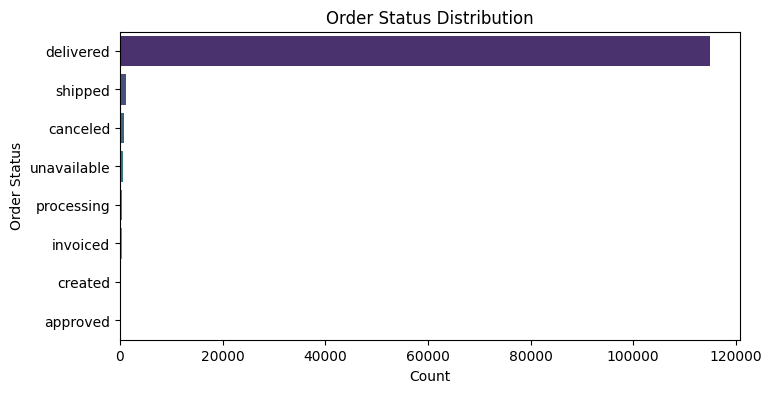

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count of each order status
plt.figure(figsize=(8, 4))
sns.countplot(y=rfm_data['order_status'], order=rfm_data['order_status'].value_counts().index, palette='viridis')
plt.title("Order Status Distribution")
plt.xlabel("Count")
plt.ylabel("Order Status")
plt.show()


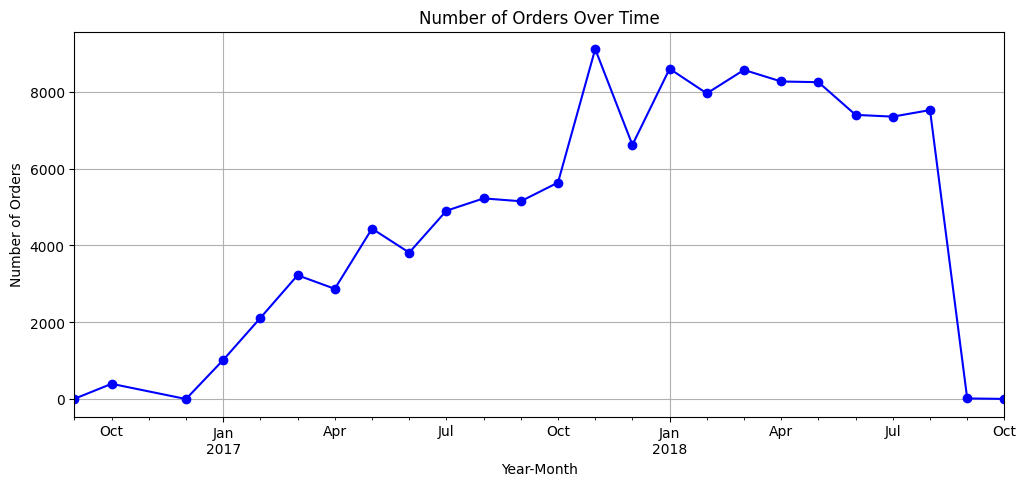

In [22]:
# Extract year-month for trend analysis
rfm_data['order_month'] = rfm_data['order_purchase_timestamp'].dt.to_period('M')

# Plot purchase trends
plt.figure(figsize=(12, 5))
rfm_data['order_month'].value_counts().sort_index().plot(kind='line', marker='o', color='b')
plt.title("Number of Orders Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Number of Orders")
plt.grid()
plt.show()


In [23]:
#Explore Payment Type Preferences
#To see if a payment type is linked to higher spending:
rfm_data.groupby("payment_type")["payment_value"].mean().sort_values(ascending=False)


payment_type
credit_card    179.807426
boleto         177.402470
debit_card     151.011731
voucher         67.520242
not_defined      0.000000
Name: payment_value, dtype: float64

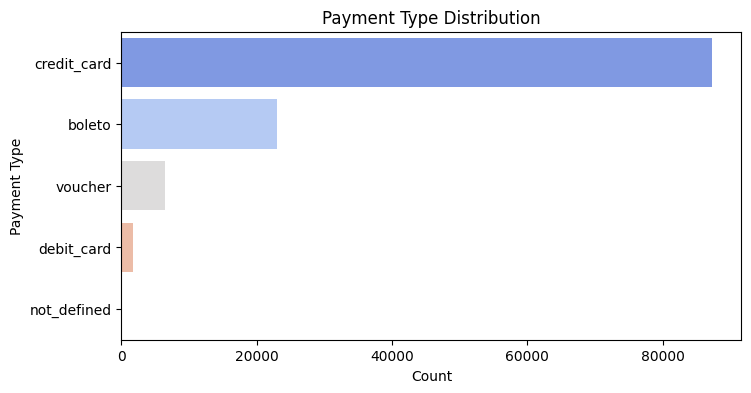

In [24]:
# Count of payment types
plt.figure(figsize=(8, 4))
sns.countplot(y=rfm_data['payment_type'], order=rfm_data['payment_type'].value_counts().index, palette='coolwarm')
plt.title("Payment Type Distribution")
plt.xlabel("Count")
plt.ylabel("Payment Type")
plt.show()


In [25]:
#Finding Which cities have high-value transactions
#Do customers in certain states pay more on average?

rfm_data.groupby("customer_city")["payment_value"].mean().sort_values(ascending=False).head(10)

customer_city
pianco                     2324.990000
nova esperanca do piria    2252.660000
engenheiro navarro         2106.550000
mariental                  1867.850000
paranatinga                1687.186667
loreto                     1643.640000
ibitita                    1534.580000
barao ataliba nogueira     1351.510000
barra longa                1341.550000
passagem                   1265.830000
Name: payment_value, dtype: float64

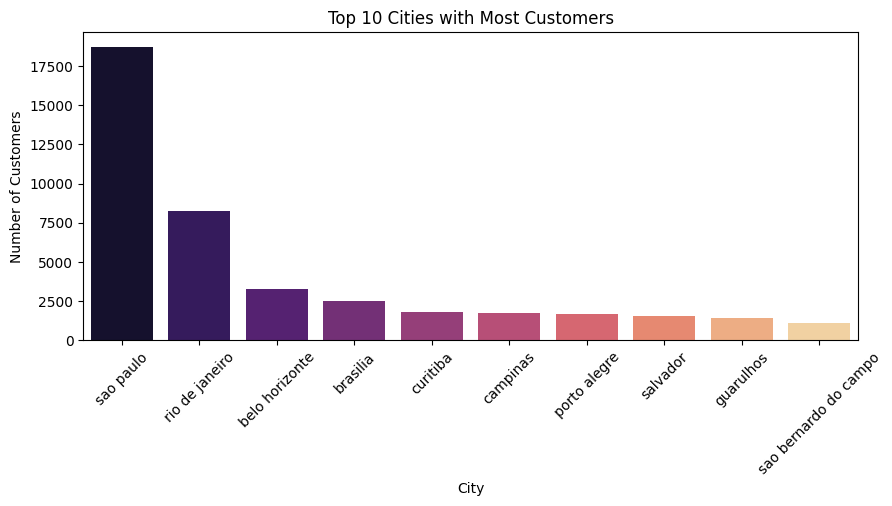

In [26]:
# Top 10 cities with most customers
top_cities = rfm_data['customer_city'].value_counts().head(10)

plt.figure(figsize=(10, 4))
sns.barplot(x=top_cities.index, y=top_cities.values, palette='magma')
plt.xticks(rotation=45)
plt.title("Top 10 Cities with Most Customers")
plt.xlabel("City")
plt.ylabel("Number of Customers")
plt.show()


In [27]:
rfm_data.loc[rfm_data['order_status'] == 'canceled', 'order_delivered_customer_date'] = pd.NaT


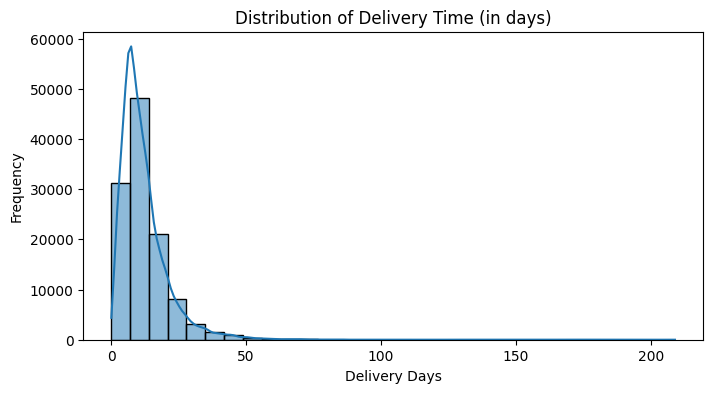

In [28]:
# Calculate delivery time
import matplotlib.pyplot as plt
rfm_data['delivery_days'] = (rfm_data['order_delivered_customer_date'] - rfm_data['order_purchase_timestamp']).dt.days

# Plot distribution of delivery time
plt.figure(figsize=(8, 4))
sns.histplot(rfm_data['delivery_days'].dropna(), bins=30, kde=True)
plt.title("Distribution of Delivery Time (in days)")
plt.xlabel("Delivery Days")
plt.ylabel("Frequency")
plt.show()


In [29]:

rfm_data.dtypes

order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
payment_type                             object
payment_value                           float64
customer_unique_id                       object
customer_city                            object
customer_state                           object
delivery_days                           float64
order_month                           period[M]
dtype: object

In [30]:
# Group by customer city and order status
city_cancellation = rfm_data[rfm_data["order_status"] == "canceled"].groupby("customer_city")["payment_value"].mean().sort_values(ascending=False)
print(city_cancellation.head(10))  # Top 10 cities with highest average canceled payment_value


customer_city
novo hamburgo    2404.720000
paranagua        1950.200000
goiania          1551.040000
quissama         1400.740000
porto alegre     1381.022000
florianopolis    1371.608000
porto seguro     1346.410000
piratininga       898.510000
uberaba           845.088000
praia grande      818.563333
Name: payment_value, dtype: float64


In [31]:
# Compare average delivery time for different order statuses
delivery_analysis = rfm_data.groupby("order_status")["delivery_days"].mean().sort_values()
print(delivery_analysis)

order_status
delivered      12.018873
approved             NaN
canceled             NaN
created              NaN
invoiced             NaN
processing           NaN
shipped              NaN
unavailable          NaN
Name: delivery_days, dtype: float64


In [78]:
#The cleaned data after EDA
rfm_data

,order_id,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,payment_type,payment_value,customer_unique_id,customer_city,customer_state,delivery_days,order_month,cohort_month,cohort_index
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,credit_card,18.12,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,8.0,2017-10,2017-09,1
1,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,voucher,2.00,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,8.0,2017-10,2017-09,1
2,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,voucher,18.59,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,8.0,2017-10,2017-09,1
3,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 14:31:00,2018-08-07 15:27:45,boleto,141.46,af07308b275d755c9edb36a90c618231,barreiras,BA,13.0,2018-07,2018-07,0
4,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 13:50:00,2018-08-17 18:06:29,credit_card,179.12,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,GO,9.0,2018-08,2018-08,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118429,63943bddc261676b46f01ca7ac2f7bd8,delivered,2018-02-06 12:58:58,2018-02-07 23:22:42,2018-02-28 17:37:56,credit_card,195.00,da62f9e57a76d978d02ab5362c509660,praia grande,SP,22.0,2018-02,2018-02,0
118430,83c1379a015df1e13d02aae0204711ab,delivered,2017-08-27 14:46:43,2017-08-28 20:52:26,2017-09-21 11:24:17,credit_card,271.01,737520a9aad80b3fbbdad19b66b37b30,nova vicosa,BA,24.0,2017-08,2017-08,0
118431,11c177c8e97725db2631073c19f07b62,delivered,2018-01-08 21:28:27,2018-01-12 15:35:03,2018-01-25 23:32:54,credit_card,441.16,5097a5312c8b157bb7be58ae360ef43c,japuiba,RJ,17.0,2018-01,2018-01,0
118432,11c177c8e97725db2631073c19f07b62,delivered,2018-01-08 21:28:27,2018-01-12 15:35:03,2018-01-25 23:32:54,credit_card,441.16,5097a5312c8b157bb7be58ae360ef43c,japuiba,RJ,17.0,2018-01,2018-01,0


## Cohort Analysis: Understanding Customer Retention Trends
### 📌 Overview
Cohort analysis helps in understanding customer behavior over time by grouping customers based on their first purchase and tracking their engagement in subsequent months. This allows us to analyze customer retention trends, identify patterns, and measure how long customers continue making purchases after their initial transaction.

### 🔍 Why This is Important
Helps identify how well the business retains customers.
Provides insights into customer loyalty and repeat purchase behavior.
Helps in making data-driven decisions for marketing and customer relationship strategies.
### 🛠️ Methodology
Assign Customers to a Cohort – Customers are grouped based on their first purchase month.
Track Customer Activity – Each cohort is analyzed to see how many customers return to make purchases in later months.
Build a Cohort Retention Matrix – A table is created showing the percentage of customers retained over time.
Visualize the Data – A heatmap or trend chart is used to display customer retention patterns.
This analysis will provide insights into how customer engagement changes over time and help optimize retention strategies. 🚀

In [79]:
# Ensure CohortMonth is properly assigned,which is the first month of transaction
rfm_data['cohort_month'] = rfm_data.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('M')

In [80]:
# Ensure CohortIndex is properly calculated
rfm_data['cohort_index'] = (
    (rfm_data['order_purchase_timestamp'].dt.year - rfm_data['cohort_month'].dt.year) * 12 +
    (rfm_data['order_purchase_timestamp'].dt.month - rfm_data['cohort_month'].dt.month))

In [81]:
rfm_data

,order_id,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,payment_type,payment_value,customer_unique_id,customer_city,customer_state,delivery_days,order_month,cohort_month,cohort_index
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,credit_card,18.12,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,8.0,2017-10,2017-09,1
1,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,voucher,2.00,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,8.0,2017-10,2017-09,1
2,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,voucher,18.59,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP,8.0,2017-10,2017-09,1
3,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-07-26 14:31:00,2018-08-07 15:27:45,boleto,141.46,af07308b275d755c9edb36a90c618231,barreiras,BA,13.0,2018-07,2018-07,0
4,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-08 13:50:00,2018-08-17 18:06:29,credit_card,179.12,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,GO,9.0,2018-08,2018-08,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118429,63943bddc261676b46f01ca7ac2f7bd8,delivered,2018-02-06 12:58:58,2018-02-07 23:22:42,2018-02-28 17:37:56,credit_card,195.00,da62f9e57a76d978d02ab5362c509660,praia grande,SP,22.0,2018-02,2018-02,0
118430,83c1379a015df1e13d02aae0204711ab,delivered,2017-08-27 14:46:43,2017-08-28 20:52:26,2017-09-21 11:24:17,credit_card,271.01,737520a9aad80b3fbbdad19b66b37b30,nova vicosa,BA,24.0,2017-08,2017-08,0
118431,11c177c8e97725db2631073c19f07b62,delivered,2018-01-08 21:28:27,2018-01-12 15:35:03,2018-01-25 23:32:54,credit_card,441.16,5097a5312c8b157bb7be58ae360ef43c,japuiba,RJ,17.0,2018-01,2018-01,0
118432,11c177c8e97725db2631073c19f07b62,delivered,2018-01-08 21:28:27,2018-01-12 15:35:03,2018-01-25 23:32:54,credit_card,441.16,5097a5312c8b157bb7be58ae360ef43c,japuiba,RJ,17.0,2018-01,2018-01,0


## Cohort Analysis of Customer Retention
This table shows the number of returning customers over time, with each row representing a cohort based on their first purchase month.
The numbers indicate how many customers made repeat purchases in subsequent months. Retention declines over time, with some cohorts showing
stronger repeat engagement than others.

In [82]:
cohort_counts = rfm_data.groupby(["cohort_month", "cohort_index"])["customer_unique_id"].nunique().unstack()

cohort_counts.head()

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort_month,,,,,,,,,,,,,,,,,,,,
2016-09,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,321.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,2.0
2016-12,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,764.0,3.0,2.0,1.0,3.0,1.0,4.0,1.0,1.0,NaN,3.0,1.0,6.0,3.0,1.0,1.0,2.0,3.0,1.0,NaN
2017-02,1752.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,3.0,4.0,2.0,5.0,3.0,3.0,2.0,1.0,1.0,4.0,NaN,NaN


In [83]:
#Calculating Retention Rate,the table shows retension in percentage
cohort_sizes = cohort_counts.iloc[:, 0]  # First column (Cohort size)
retention = cohort_counts.divide(cohort_sizes, axis=0).round(3) * 100
retention.head()

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort_month,,,,,,,,,,,,,,,,,,,,
2016-09,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,100.0,NaN,NaN,NaN,NaN,NaN,0.3,NaN,NaN,0.3,NaN,0.3,NaN,0.3,NaN,0.3,NaN,0.3,0.6,0.6
2016-12,100.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,100.0,0.4,0.3,0.1,0.4,0.1,0.5,0.1,0.1,NaN,0.4,0.1,0.8,0.4,0.1,0.1,0.3,0.4,0.1,NaN
2017-02,100.0,0.2,0.3,0.1,0.4,0.1,0.2,0.2,0.2,0.2,0.1,0.3,0.2,0.2,0.1,0.1,0.1,0.2,NaN,NaN


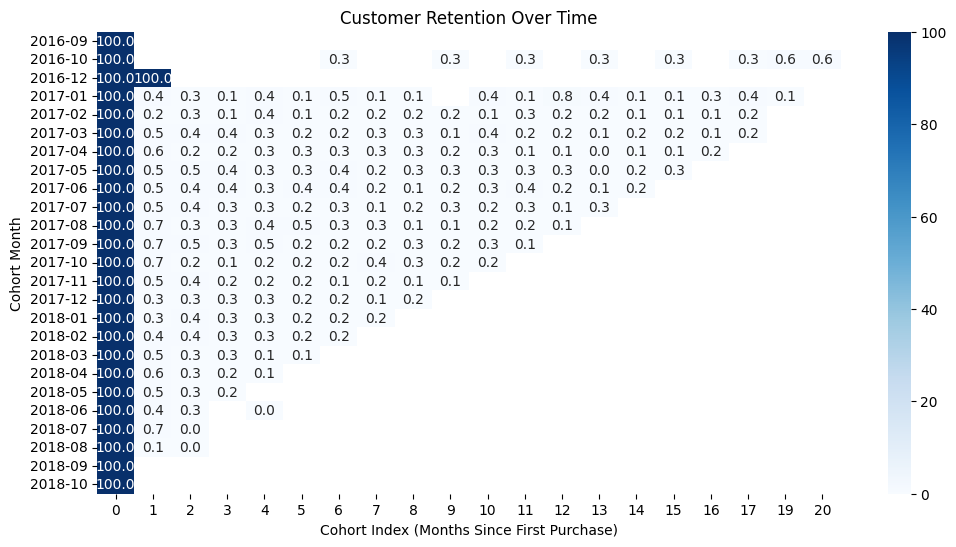

In [36]:
#Visualisation of the retension rates
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(retention, annot=True, fmt=".1f", cmap="Blues")
plt.title("Customer Retention Over Time")
plt.ylabel("Cohort Month")
plt.xlabel("Cohort Index (Months Since First Purchase)")
plt.show()


In [84]:
#Average Price to track the price or  revenue from each customer in each cohorts
avg_price = rfm_data.groupby(["cohort_month", "cohort_index"])["payment_value"].mean().unstack(1).round(1)

avg_price.head()

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort_month,,,,,,,,,,,,,,,,,,,,
2016-09,101.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,191.7,NaN,NaN,NaN,NaN,NaN,111.3,NaN,NaN,356.1,NaN,28.4,NaN,163.5,NaN,381.0,NaN,116.6,192.0,90.7
2016-12,19.6,19.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,186.0,56.9,57.4,89.7,82.1,69.3,170.9,105.2,47.0,NaN,142.4,66.6,135.6,117.2,93.7,104.6,109.7,118.1,50.9,NaN
2017-02,165.7,134.0,106.6,59.4,156.0,37.1,237.4,91.4,214.3,161.2,171.6,90.9,105.0,132.4,90.8,136.8,291.7,115.1,NaN,NaN


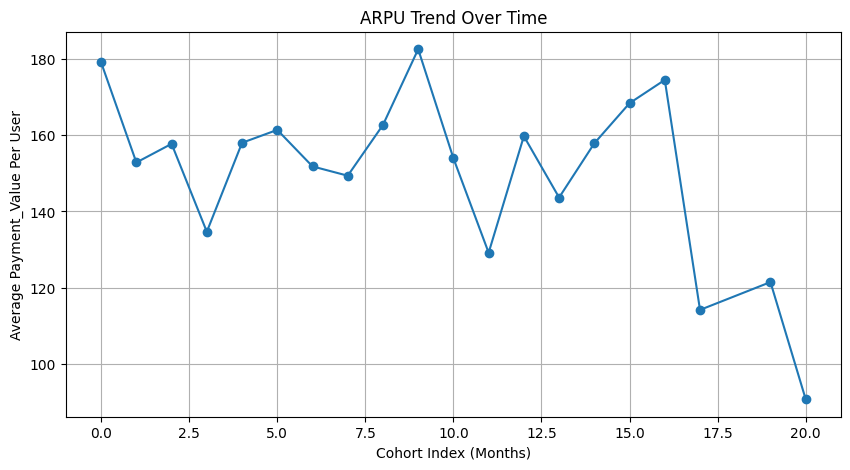

In [85]:
plt.figure(figsize=(10, 5))
avg_price.mean(axis=0).plot(marker="o")
plt.title("ARPU Trend Over Time")
plt.xlabel("Cohort Index (Months)")
plt.ylabel("Average Payment_Value Per User")
plt.grid(True)
plt.show()


## Customer Segmentation Using RFM Analysis: Understanding Purchase Behavior and Loyalty
In this section, we perform RFM (Recency, Frequency, and Monetary) analysis to segment customers based on their purchasing behavior.
This approach helps in identifying high-value customers, loyal buyers, and those at risk of churning. By analyzing how recently a customer
made a purchase (Recency), how often they buy (Frequency), and how much they spend (Monetary value), businesses can tailor marketing strategies
to improve customer retention and maximize revenue.

In [86]:
#Setting the reference date for the analysis
from datetime import datetime, timedelta
snapshot_date=rfm_data['order_purchase_timestamp'].max()+timedelta(days=1)

snapshot_date=snapshot_date.normalize()
print("Snapshot Date:", snapshot_date)

Snapshot Date: 2018-10-18 00:00:00


In [87]:
# Recency: Calculate days since last purchase for each customer
rfm_recency = rfm_data.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()

rfm_recency['Recency'] = (reference_date - rfm_recency['order_purchase_timestamp']).dt.days
rfm_recency = rfm_recency[['customer_unique_id', 'Recency']]  # Keep only relevant columns


# Frequency: Count the total number of orders per customer
rfm_frequency = rfm_data.groupby('customer_unique_id')['order_id'].nunique().reset_index()
rfm_frequency.rename(columns={'order_id': 'Frequency'}, inplace=True)


# Monetary: Sum of total money spent per customer
rfm_monetary = rfm_data.groupby('customer_unique_id')['payment_value'].sum().reset_index()
rfm_monetary.rename(columns={'payment_value': 'Monetary'}, inplace=True)

In [89]:
# Merge Recency, Frequency, and Monetary data into one DataFrame
rfm = rfm_recency.merge(rfm_frequency, on='customer_unique_id', how='left')
rfm = rfm.merge(rfm_monetary, on='customer_unique_id', how='left')
rfm

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,161,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,27.19
2,0000f46a3911fa3c0805444483337064,586,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,337,1,196.89
...,...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,496,1,4134.84
96092,fffea47cd6d3cc0a88bd621562a9d061,311,1,84.58
96093,ffff371b4d645b6ecea244b27531430a,618,1,112.46
96094,ffff5962728ec6157033ef9805bacc48,169,1,133.69


In [90]:
# Assign scores based on quantiles (higher score means better value)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])  # Lower recency is better (recent purchase)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])  # Higher frequency is better
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])  # Higher monetary value is better

# Combine RFM scores into a single RFM Score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)


In [94]:
rfm

,customer_unique_id,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,0000366f3b9a7992bf8c76cfdf3221e2,161,1,141.90,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,27.19,4,1,1,411
2,0000f46a3911fa3c0805444483337064,586,1,86.22,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,337,1,196.89,2,1,4,214
...,...,...,...,...,...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,496,1,4134.84,1,5,5,155
96092,fffea47cd6d3cc0a88bd621562a9d061,311,1,84.58,3,5,2,352
96093,ffff371b4d645b6ecea244b27531430a,618,1,112.46,1,5,3,153
96094,ffff5962728ec6157033ef9805bacc48,169,1,133.69,4,5,3,453


In [97]:
# Define segmentation function
def assign_segment(row):
    R, F, M = row['Recency'], row['Frequency'], row['Monetary']

    if R <= 60 and F >= 4 and M >= 400:
        return "Best Customers"
    elif R <= 90 and F >= 3 and M >= 300:
        return "Loyal Customers"
    elif R > 180 and F >= 2 and M >= 300:
        return "At Risk"
    elif R > 365 and F == 1 and M <= 200:
        return "Lost Customers"
    elif R <= 90 and 2 <= F <= 3 and M >= 300:
        return "Potential Loyalists"
    elif R > 90 and F == 1 and M >= 400:
        return "Big Spenders (One-Time Buyers)"
    else:
        return "Other"

# Apply segmentation
rfm['Customer_Segment'] = rfm.apply(assign_segment, axis=1)

# Count number of customers in each segment
segment_counts = rfm['Customer_Segment'].value_counts()

# Print results
rfm

,customer_unique_id,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Customer_Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,161,1,141.90,4,1,4,414,Other
1,0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,27.19,4,1,1,411,Other
2,0000f46a3911fa3c0805444483337064,586,1,86.22,1,1,2,112,Lost Customers
3,0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62,2,1,1,211,Lost Customers
4,0004aac84e0df4da2b147fca70cf8255,337,1,196.89,2,1,4,214,Other
...,...,...,...,...,...,...,...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,496,1,4134.84,1,5,5,155,Big Spenders (One-Time Buyers)
96092,fffea47cd6d3cc0a88bd621562a9d061,311,1,84.58,3,5,2,352,Other
96093,ffff371b4d645b6ecea244b27531430a,618,1,112.46,1,5,3,153,Lost Customers
96094,ffff5962728ec6157033ef9805bacc48,169,1,133.69,4,5,3,453,Other


In [99]:
#Count of Segments
segments=rfm['Customer_Segment'].value_counts()
segments

Customer_Segment
Other                             66001
Lost Customers                    21076
Big Spenders (One-Time Buyers)     8066
At Risk                             803
Potential Loyalists                 118
Loyal Customers                      29
Best Customers                        3
Name: count, dtype: int64